First load in the required external libraries for python

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pylab as plt
import cmocean 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import urllib.request as urllib2
import xarray as xr
from scipy import stats

Now load in some example data file. First we construct a python string containing the location of the file then load this as an 'xarray' (a nice way of viewing and handling the tabulated data)

In [22]:
date = '2011-06-01-01-1_0'
fn = 'portal.nersc.gov/project/ClimateNet/climatenet_new/test/data-'+date+'.nc'
ds = xr.open_dataset(fn)

View the tabulated data (note this is interactive in a jupter notebook)

In [14]:
ds

<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 1)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 'data-2011-06-01-01-1.nc'
Data variables: (12/17)
    TMQ      (time, lat, lon) float32 ...
    U850     (time, lat, lon) float32 ...
    V850     (time, lat, lon) float32 ...
    UBOT     (time, lat, lon) float32 ...
    VBOT     (time, lat, lon) float32 ...
    QREFHT   (time, lat, lon) float32 ...
    ...       ...
    TS       (time, lat, lon) float32 ...
    TREFHT   (time, lat, lon) float32 ...
    Z1000    (time, lat, lon) float32 ...
    Z200     (time, lat, lon) float32 ...
    ZBOT     (time, lat, lon) float32 ...
    LABELS   (lat, lon) int64 ...

We can view the dimensions (which are latitude and longitude), or the values of each of the measurements at these coordinates as follows

In [5]:
#Load in the values of the latitude and longitude from the dataset, and print the array of longitude values (which unsurprisingly go from 0 to 360)
lon = ds.lon.values
lat = ds.lat.values 
print(lon) 

[0.000000e+00 3.125000e-01 6.250000e-01 ... 3.590625e+02 3.593750e+02
 3.596875e+02]


In [6]:
#Load in e.g. zonal winds at 850mb pressure surface. We can see that this is an array with three dimensions. 
#The first dimension is time (currently we have only loaded one timestep). 
#The second two dimensions are latitude and longitude.
U850 = ds.U850.values
V850 = ds.V850.values
print(U850.shape)

(1, 768, 1152)


In [7]:
#Select the first column of the first dimension using square brackets (python starts indexing at 0) and print values from the 2D array.
#These are the values of U850 at each latitude and longitude
print(U850[0])

[[-3.701085  -3.6890082 -3.6768215 ... -3.736654  -3.7249084 -3.713052 ]
 [-4.385527  -4.3593483 -4.3328357 ... -4.462033  -4.436871  -4.4113684]
 [-6.861711  -6.8401723 -6.818181  ... -6.9236383 -6.9034414 -6.8827996]
 ...
 [ 5.684656   5.6944284  5.7040105 ...  5.6542     5.664543   5.6746945]
 [ 5.929916   5.9488187  5.96755   ...  5.8721867  5.8916     5.910843 ]
 [ 5.8953314  5.922173   5.948838  ...  5.813758   5.841123   5.8683147]]


We want to visualize the data in some useful way. Since we have values of different climate variables at each latitude and longitude, it makes sense to do a contour plot. We can do special contour plots for data in latitude-longitude format using the module cartopy loaded above. This is set up as follows:

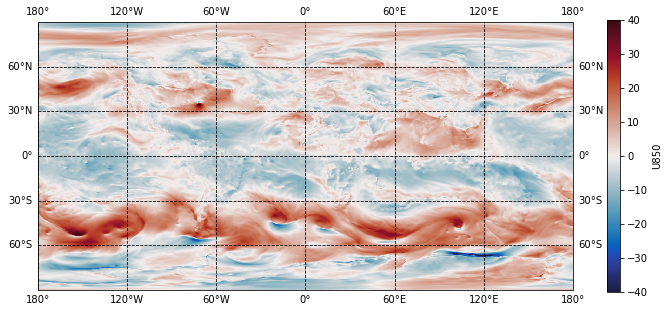

In [8]:
projection=ccrs.PlateCarree();
figsize = (12,5)
# Some other projections we might try (try uncommenting these!)
# projection=ccrs.Robinson();
# projection=ccrs.LambertCylindrical();

#for future reference, define a function to set up our map
def map_setup(figsize,projection):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection=projection)
    ax.add_feature(cfeature.LAND, facecolor='k')
    ax.gridlines(draw_labels=True, color='k', linestyle='--')  
    return fig, ax

fig, ax = map_setup(figsize,projection) 
image = ax.pcolormesh(lon, lat,U850[0], transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=-40,vmax=40) 
#The cmocean module has very nice colour maps. They are listed here: https://matplotlib.org/cmocean/
fig.colorbar(image, ax=ax, label='U850')

We can see the distinctive strong westerly winds over the Southern ocean in the above plot. Now try loading in some other variables from the dataset and plotting those.

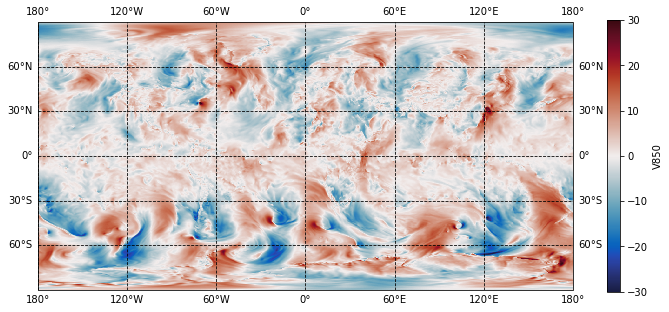

In [9]:
projection=ccrs.PlateCarree();
figsize = (12,5)

fig, ax = map_setup(figsize,projection) 
image = ax.pcolormesh(lon, lat,V850[0], transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=-30, vmax=30) 
fig.colorbar(image, ax=ax, label='V850')

Now load in data from multiple dates into the same array.

In [6]:
import glob
dates = glob.glob("portal.nersc.gov/project/ClimateNet/climatenet_new/test/data-*.nc")
series = xr.open_mfdataset(dates)

In [7]:
series

<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 31)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 'data-2011-06-01-01-1.nc' ... 'data-2013-09-27-01-...
Data variables: (12/17)
    TMQ      (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    U850     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    V850     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    UBOT     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    VBOT     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    QREFHT   (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    ...       ...
    TS       (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    TREFHT   (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    Z1000    (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    Z200     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    ZBOT     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    LABELS   (time, lat, lon) int64 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>